In [1]:
using PauliPropagation
using Plots
using Printf
using LinearAlgebra
using LaTeXStrings
using ProgressMeter

In [3]:
function getnewimaginarypaulistring(gate::MaskedPauliRotation, pstr::PauliStringType)
    new_pstr, sign = pauliprod(gate.generator_mask, pstr, gate.qinds)
    return new_pstr, -1im * sign
end


function PauliPropagation.applytoall!(gate::PauliRotation, theta::ComplexF64, psum, aux_psum; kwargs...)
    # NOTE: This is for imaginary time evolution!
    if real(theta) > 0.0
        throw(ArgumentError("Parameter `theta` needs to be fully imaginary. Got theta=$theta"))
    end

    
    # turn the PauliRotation gate into a MaskedPauliRotation gate
    # this allows for faster operations
    gate = PauliPropagation._tomaskedpaulirotation(gate, paulitype(psum))

    # pre-compute the sinh and cosh values because they are used for every Pauli string that does not commute with the gate
    cosh_val = cos(theta)
    sinh_val = sin(theta)
    # loop over all Pauli strings and their coefficients in the Pauli sum
    for (pstr, coeff) in psum

        if !commutes(gate, pstr)
            # if the gate does not commute with the pauli string, do nothing
            continue
        end

        # else we know the gate will split the Pauli string into two
        coeff1 = real(coeff * cosh_val)
        new_pstr, sign = getnewimaginarypaulistring(gate, pstr)
        coeff2 = real(coeff * sinh_val * sign)

        # set the coefficient of the original Pauli string
        set!(psum, pstr, coeff1)

        # set the coefficient of the new Pauli string in the aux_psum
        # we can set the coefficient because PauliRotations create non-overlapping new Pauli strings
        set!(aux_psum, new_pstr, coeff2)
    end

    return
end


function PauliPropagation.applymergetruncate!(gate, psum, aux_psum, thetas, param_idx; max_weight=Inf, min_abs_coeff=1e-10, max_freq=Inf, max_sins=Inf, customtruncfunc=nothing, normalization=false, kwargs...)

    # Pick out the next theta if gate is a ParametrizedGate.
    # Else set the paramter to nothing for clarity that theta is not used.
    if gate isa ParametrizedGate
        theta = thetas[param_idx]
        # If the gate is parametrized, decrement theta index by one.
        param_idx -= 1
    else
        theta = nothing
    end
    # Apply the gate to all Pauli strings in psum, potentially writing into auxillary aux_psum in the process.
    # The pauli sums will be changed in-place
    applytoall!(gate, theta, psum, aux_psum; kwargs...)
    
    # Any contents of psum and aux_psum are merged into the larger of the two, which is returned as psum.
    # The other is emptied and returned as aux_psum.
    psum, aux_psum = mergeandempty!(psum, aux_psum)

    nq = psum.nqubits    
    if normalization
        min_abs_coeff = min_abs_coeff * getcoeff(psum, :I, 1)
    end
    
    # Check truncation conditions on all Pauli strings in psum and remove them if they are truncated.
    PauliPropagation.checktruncationonall!(psum; max_weight, min_abs_coeff, max_freq, max_sins, customtruncfunc)

    return psum, aux_psum, param_idx
end

In [272]:
function spinEvolution(circuit, nl, nq, index; max_weight=nq, min_abs_coeff=0)
    # Evolves Z_index for nl layers of the circuit using real time evolution.
    spin = PauliString(nq, :Z, index)
    psum = PauliSum(spin)
    for layers in 1:nl
        # Apply the circuit to the Pauli sum
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff)
    end
    return psum
end

function thermalStateExpectation(circuit, nl, nq, observables; max_weight=nq, min_abs_coeff=0)
    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)

    expectations = Complex{Float32}[]

    for layers in 1:nl
        psum = propagate!(circuit, psum; max_weight, min_abs_coeff, normalization=true)  
    end
    
    for operator in observables
        expectation = operator.coeff*getcoeff(psum, operator) 
        expectations = push!(expectations, expectation)
    end
    return sum(expectations/ getcoeff(psum, pstr))
end

function dynamicalSpinCorrelationThermal(realCircuit, imaginaryCircuit, nlReal, nlImag, nq, index1, index2; max_weight=nq, min_abs_coeff=0)
    evolvedSpin = spinEvolution(realCircuit, nlReal, nq, index1; max_weight, min_abs_coeff)
    spin2 = PauliString(nq, :Z, index2)

    # Transform evolvedSpin to a PauliSum to do the multiplication
    evolvedSpin = topaulistrings(evolvedSpin)
    observable = []
    for i in evolvedSpin
        pstr = pauliprod(i, spin2)
        push!(observable, pstr)
    end

    expectations = thermalStateExpectation(imaginaryCircuit, nlImag, nq, observable; max_weight, min_abs_coeff)
    return expectations
end

dynamicalSpinCorrelationThermal (generic function with 3 methods)

In [202]:
function imaginaryTimeEvolution(h::Matrix, beta::Float64)
    operator = exp(-beta*h)
    return operator/tr(exp(-beta*h))
end

function evolvedOperator(O::Matrix, h::Matrix, t::Float64)
    U = exp(-im * h * t)
    return U' * O * U
end

function interpretPauli(p::String)
    I = [1 0; 0 1]
    X = [0 1; 1 0]
    Y = [0 -1im; 1im 0]
    Z = [1 0; 0 -1]

    if p[1] == 'I'
        mat = I
    elseif p[1] == 'X'
        mat = X
    elseif p[1] == 'Y'
        mat = Y
    elseif p[1] == 'Z'
        mat = Z
    end

    for i in 2:length(p)
        if p[i] == 'I'
            mat = kron(mat, I)
        elseif p[i] == 'X'
            mat = kron(mat, X)
        elseif p[i] == 'Y'
            mat = kron(mat, Y)
        elseif p[i] == 'Z'
            mat = kron(mat, Z)
        end
    end
    return mat
end

function exactThermalDynamicalCorrelation(h::Matrix, beta::Float64, t::Float64, O1::String, O2::String)
    rho = imaginaryTimeEvolution(h, beta)

    O1_mat = interpretPauli(O1)
    O2_mat = interpretPauli(O2)
    O1t = evolvedOperator(O1_mat, h, t)
    C = tr(rho * (O1t * O2_mat))

    return C
end

exactThermalDynamicalCorrelation (generic function with 1 method)

In [208]:
function XMatrix(n::Int, i::Int)
    Xmat = [0 1; 1 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Xmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Xmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function YMatrix(n::Int, i::Int)
    Ymat = [0 -im; im 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Ymat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Ymat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function ZMatrix(n::Int, i::Int)
    Zmat = [1 0; 0 -1]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Zmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Zmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

ZMatrix (generic function with 1 method)

In [209]:
nq = 5
H = I(2^nq)
for i in 1:nq
    H += ZMatrix(nq, i)
    if i < nq
        H += XMatrix(nq, i)*XMatrix(nq, i+1)
    end
end

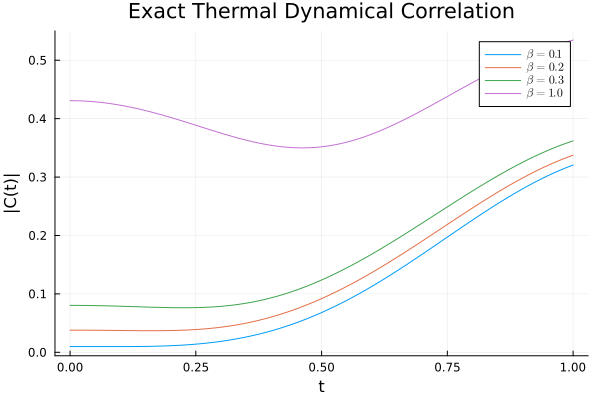

In [291]:
str1 = "ZIIII"
str2 = "IZIII"
beta = [0.1,0.2,0.3,1.0]
time = range(0.0, 1, length = 100)
Cexact = zeros(ComplexF64, length(beta), length(time))
for i in 1:length(beta)
    for j in 1:length(time)
        Cexact[i, j] = exactThermalDynamicalCorrelation(H, beta[i], time[j], str1, str2)
    end
end
plot()
for i in 1:length(beta)
    plot!(time, abs.(Cexact[i, :]), label = "\$\\beta = $(round(beta[i], digits=2))\$", xlabel = "t", ylabel = "|C(t)|", title = "Exact Thermal Dynamical Correlation", legend = :topright)
end
display(plot!())


In [328]:
thetaIm = 0.01im
θ = thetaIm
nq = 5

topology = bricklayertopology(nq)

# the circuit
imagCircuit = Gate[]
nl = 1
for i in 1:nl
    #append!(circuit, PauliRotation(:X, ii, θ) for ii in 1:nq);
    append!(imagCircuit, PauliRotation(:Z, ii, θ) for ii in 1:nq);
    append!(imagCircuit, PauliRotation([:X, :X], pair, θ) for pair in topology);
end

thetaRe = 0.01
θ = thetaRe

# the circuit
realCircuit = Gate[]
nl = 1
for i in 1:nl
    #append!(circuit, PauliRotation(:X, ii, θ) for ii in 1:nq);
    append!(realCircuit, PauliRotation(:Z, ii, θ) for ii in 1:nq);
    append!(realCircuit, PauliRotation([:X, :X], pair, θ) for pair in topology);
end


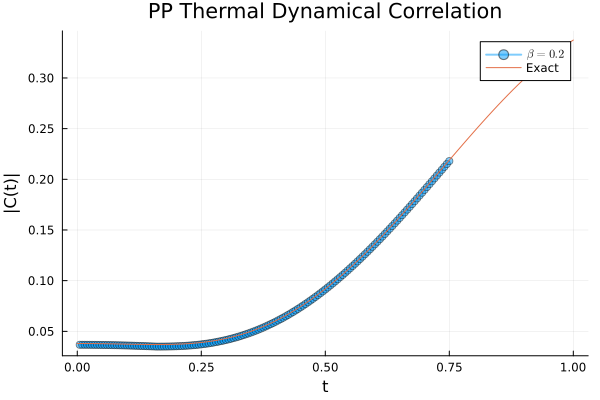

In [316]:
spin_i = 1
spin_j = 2
nlReal = 150
timeLayer = range(thetaRe/2, thetaRe*nlReal/2, length = nlReal)
nlImag = [20]
C = zeros(ComplexF64, length(nlImag), nlReal)
for i in 1:length(nlImag)
    for j in 1:nlReal
        C[i, j] = dynamicalSpinCorrelationThermal(realCircuit, imagCircuit, j, nlImag[i], nq, spin_i, spin_j; max_weight=3, min_abs_coeff=1e-4)
    end
end

plot()
for i in 1:length(nlImag)
    plot!(timeLayer, abs.(C[i, :]), label = "\$\\beta = $(round(imag(nlImag[i]*thetaIm), digits=2))\$", lw=2, markersize=4, marker=:circle, alpha=0.5, xlabel = "t", ylabel = "|C(t)|", title = "PP Thermal Dynamical Correlation", legend = :topright)
    plot!(time, abs.(Cexact[2, :]), label = "Exact")

end
display(plot!())



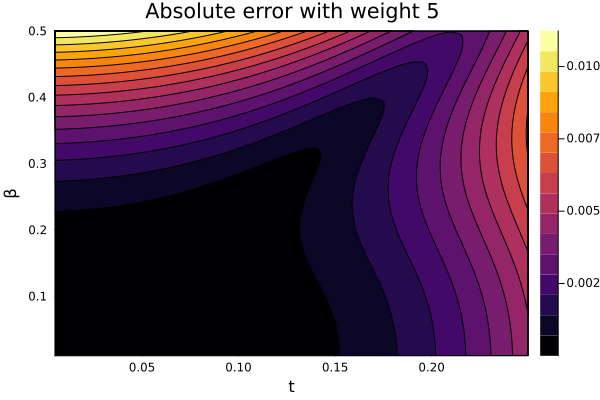

In [335]:
spin_i = 1
spin_j = 4
nlReal = 50
t = range(thetaRe/2, thetaRe*nlReal/2, length = nlReal)
nlImag = 50
beta = range(imag(thetaIm), imag(thetaIm*nlImag), length = nlImag)
C_pp = zeros(ComplexF64, nlImag, nlReal)
C_exact = zeros(ComplexF64, nlImag, nlReal)
error = zeros(ComplexF64, nlImag, nlReal)
for i in 1:nlImag
    for j in 1:nlReal
        C_pp[i, j] = dynamicalSpinCorrelationThermal(realCircuit, imagCircuit, j, i, nq, spin_i, spin_j; max_weight=5, min_abs_coeff=0)
        C_exact[i, j] = exactThermalDynamicalCorrelation(H, beta[i], t[j], str1, str2)
    end
end
error = abs.(C_exact - C_pp)


contour(
    t, beta, error,
    xlabel = "t",
    ylabel = "β",
    title = "Absolute error with weight 5",
    fill = true,
    colorbar = true
)


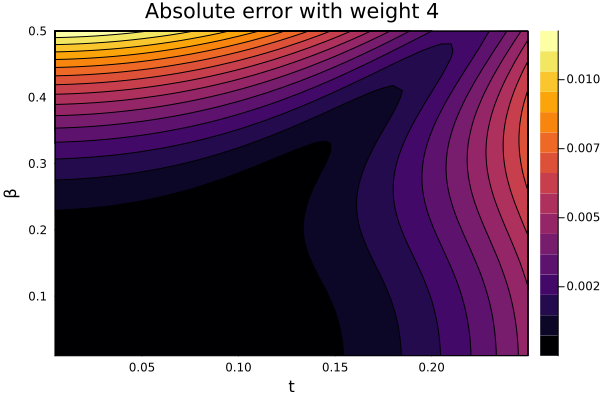

In [336]:
spin_i = 1
spin_j = 4
nlReal = 50
t = range(thetaRe/2, thetaRe*nlReal/2, length = nlReal)
nlImag = 50
beta = range(imag(thetaIm), imag(thetaIm*nlImag), length = nlImag)
C_pp = zeros(ComplexF64, nlImag, nlReal)
C_exact = zeros(ComplexF64, nlImag, nlReal)
error = zeros(ComplexF64, nlImag, nlReal)
for i in 1:nlImag
    for j in 1:nlReal
        C_pp[i, j] = dynamicalSpinCorrelationThermal(realCircuit, imagCircuit, j, i, nq, spin_i, spin_j; max_weight=4, min_abs_coeff=0)
        C_exact[i, j] = exactThermalDynamicalCorrelation(H, beta[i], t[j], str1, str2)
    end
end
error = abs.(C_exact - C_pp)


contour(
    t, beta, error,
    xlabel = "t",
    ylabel = "β",
    title = "Absolute error with weight 4",
    fill = true,
    colorbar = true
)


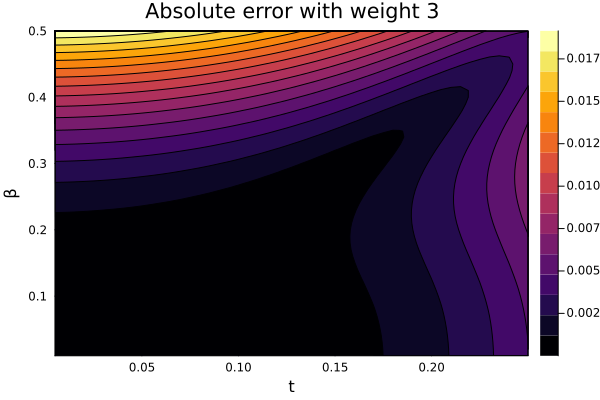

In [337]:
spin_i = 1
spin_j = 4
nlReal = 50
t = range(thetaRe/2, thetaRe*nlReal/2, length = nlReal)
nlImag = 50
beta = range(imag(thetaIm), imag(thetaIm*nlImag), length = nlImag)
C_pp = zeros(ComplexF64, nlImag, nlReal)
C_exact = zeros(ComplexF64, nlImag, nlReal)
error = zeros(ComplexF64, nlImag, nlReal)
for i in 1:nlImag
    for j in 1:nlReal
        C_pp[i, j] = dynamicalSpinCorrelationThermal(realCircuit, imagCircuit, j, i, nq, spin_i, spin_j; max_weight=3, min_abs_coeff=0)
        C_exact[i, j] = exactThermalDynamicalCorrelation(H, beta[i], t[j], str1, str2)
    end
end
error = abs.(C_exact - C_pp)


contour(
    t, beta, error,
    xlabel = "t",
    ylabel = "β",
    title = "Absolute error with weight 3",
    fill = true,
    colorbar = true
)
